# ------------------------
#  Project Overview
# -----------------------
# This Project tackles the challenge of forecasting bus seat demand 15 days before the date of journey. We use historical booking and search data to engineer meaningful features, build predictive models, and evaluate them using RMSE.

In [1]:
## Importing important Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb

In [3]:


# Loading the Excel file
train = pd.read_csv("train.csv")
test = pd.read_csv("test_8gqdJqH.csv")
transactions = pd.read_csv("transactions.csv")


In [4]:
train.shape

(67200, 4)

In [5]:
transactions.shape

(2266100, 11)

In [6]:
test.shape

(5900, 4)

In [7]:
transactions.head(8)

,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd
0,2023-03-01,2023-01-30,45,46,Karnataka,Tamil Nadu,Tier 1,Tier 1,8.0,76.0,30
1,2023-03-01,2023-01-30,46,45,Tamil Nadu,Karnataka,Tier 1,Tier 1,8.0,70.0,30
2,2023-03-01,2023-01-30,45,47,Karnataka,Andhra Pradesh,Tier 1,Tier 1,4.0,142.0,30
3,2023-03-01,2023-01-30,47,45,Andhra Pradesh,Karnataka,Tier 1,Tier 1,0.0,68.0,30
4,2023-03-01,2023-01-30,46,9,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,9.0,162.0,30
5,2023-03-01,2023-01-30,9,46,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,0.0,63.0,30
6,2023-03-01,2023-01-30,46,48,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,0.0,309.0,30
7,2023-03-01,2023-01-30,48,46,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,0.0,165.0,30


In [8]:
transactions['dbd'].unique()

array([30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14,
       13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [9]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266100 entries, 0 to 2266099
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   doj                 object 
 1   doi                 object 
 2   srcid               int64  
 3   destid              int64  
 4   srcid_region        object 
 5   destid_region       object 
 6   srcid_tier          object 
 7   destid_tier         object 
 8   cumsum_seatcount    float64
 9   cumsum_searchcount  float64
 10  dbd                 int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 190.2+ MB


In [10]:
print(train.isnull().sum())
print(transactions.isnull().sum())

doj                0
srcid              0
destid             0
final_seatcount    0
dtype: int64
doj                   0
doi                   0
srcid                 0
destid                0
srcid_region          0
destid_region         0
srcid_tier            0
destid_tier           0
cumsum_seatcount      0
cumsum_searchcount    0
dbd                   0
dtype: int64


In [11]:
train.head(8)

,doj,srcid,destid,final_seatcount
0,2023-03-01,45,46,2838.0
1,2023-03-01,46,45,2298.0
2,2023-03-01,45,47,2720.0
3,2023-03-01,47,45,2580.0
4,2023-03-01,46,9,4185.0
5,2023-03-01,9,46,3273.0
6,2023-03-01,46,48,4959.0
7,2023-03-01,48,46,3378.0


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67200 entries, 0 to 67199
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   doj              67200 non-null  object 
 1   srcid            67200 non-null  int64  
 2   destid           67200 non-null  int64  
 3   final_seatcount  67200 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.1+ MB


In [13]:
test.head()

,route_key,doj,srcid,destid
0,2025-02-11_46_45,2025-02-11,46,45
1,2025-01-20_17_23,2025-01-20,17,23
2,2025-01-08_02_14,2025-01-08,2,14
3,2025-01-08_08_47,2025-01-08,8,47
4,2025-01-08_09_46,2025-01-08,9,46


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900 entries, 0 to 5899
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   route_key  5900 non-null   object
 1   doj        5900 non-null   object
 2   srcid      5900 non-null   int64 
 3   destid     5900 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 184.5+ KB


In [15]:
# Converting dates
for df in [train, test, transactions]:
    df['doj'] = pd.to_datetime(df['doj'])
    if 'doi' in df.columns:
        df['doi'] = pd.to_datetime(df['doi'])
   

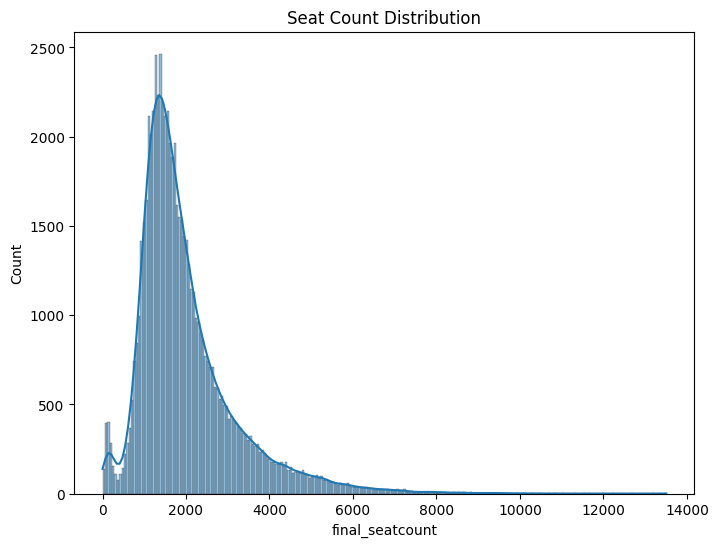

In [16]:
# Quick plot: demand distribution
plt.figure(figsize=(8,6))
sns.histplot(train['final_seatcount'], kde=True)
plt.title("Seat Count Distribution")
plt.show()

In [17]:
# Extracting date parts from DOJ
for df in [train, test, transactions]:
    df['doj_day'] = df['doj'].dt.day
    df['doj_weekday'] = df['doj'].dt.weekday
    df['doj_month'] = df['doj'].dt.month
    df['doj_is_weekend'] = df['doj'].dt.weekday.isin([5,6]).astype(int)

## ------------------
## Data Preparation
## ------------------
## We filtered transaction data to include rows where `dbd == 15` 

In [18]:
trans_15 = transactions[transactions['dbd'] == 15]

In [19]:
trans_15.shape

(73100, 15)

In [20]:
# Aggregating for matching with test
trans_agg = trans_15.groupby(['doj','srcid','destid']).agg({
    'cumsum_seatcount': 'sum',
    'cumsum_searchcount': 'sum'
}).reset_index()

In [22]:
# Creating route_key for joining
trans_agg['route_key'] = trans_agg['doj'].astype(str) + "_" + \
                         trans_agg['srcid'].astype(str) + "_" + \
                         trans_agg['destid'].astype(str)

In [23]:
trans_agg.head()

,doj,srcid,destid,cumsum_seatcount,cumsum_searchcount,route_key
0,2023-03-01,1,2,0.0,90.0,2023-03-01_1_2
1,2023-03-01,2,1,0.0,225.0,2023-03-01_2_1
2,2023-03-01,2,14,0.0,215.0,2023-03-01_2_14
3,2023-03-01,2,16,0.0,85.0,2023-03-01_2_16
4,2023-03-01,2,19,30.0,690.0,2023-03-01_2_19


In [24]:
train['route_key'] = train['doj'].astype(str) + "_" + \
                     train['srcid'].astype(str) + "_" + \
                     train['destid'].astype(str)

In [25]:
test.head()

,route_key,doj,srcid,destid,doj_day,doj_weekday,doj_month,doj_is_weekend
0,2025-02-11_46_45,2025-02-11,46,45,11,1,2,0
1,2025-01-20_17_23,2025-01-20,17,23,20,0,1,0
2,2025-01-08_02_14,2025-01-08,2,14,8,2,1,0
3,2025-01-08_08_47,2025-01-08,8,47,8,2,1,0
4,2025-01-08_09_46,2025-01-08,9,46,8,2,1,0


In [26]:
# Merging features into train/test
train = train.merge(trans_agg, on=['route_key'], how='left')
test = test.merge(trans_agg, on=['route_key'], how='left')

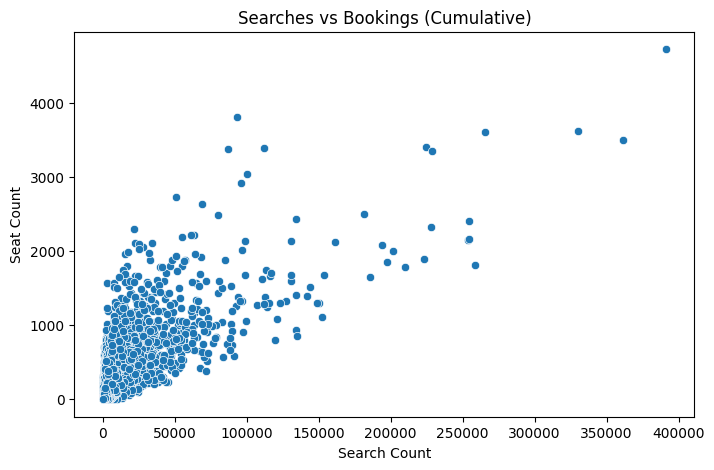

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.scatterplot(x='cumsum_searchcount', y='cumsum_seatcount', data=train)
plt.title('Searches vs Bookings (Cumulative)')
plt.xlabel('Search Count')
plt.ylabel('Seat Count')
plt.show()

In [28]:
correlation = train[['cumsum_searchcount', 'cumsum_seatcount']].corr().iloc[0,1]
print(f"Correlation: {correlation:.4f}")

Correlation: 0.7520


In [29]:
train.head()

,doj_x,srcid_x,destid_x,final_seatcount,doj_day,doj_weekday,doj_month,doj_is_weekend,route_key,doj_y,srcid_y,destid_y,cumsum_seatcount,cumsum_searchcount
0,2023-03-01,45,46,2838.0,1,2,3,0,2023-03-01_45_46,2023-03-01,45,46,16.0,480.0
1,2023-03-01,46,45,2298.0,1,2,3,0,2023-03-01_46_45,2023-03-01,46,45,34.0,352.0
2,2023-03-01,45,47,2720.0,1,2,3,0,2023-03-01_45_47,2023-03-01,45,47,36.0,892.0
3,2023-03-01,47,45,2580.0,1,2,3,0,2023-03-01_47_45,2023-03-01,47,45,18.0,1130.0
4,2023-03-01,46,9,4185.0,1,2,3,0,2023-03-01_46_9,2023-03-01,46,9,48.0,1023.0


In [30]:
# Fill missing with 0
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

C:\Users\Gaurav\AppData\Local\Temp\ipykernel_2136\2362934746.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  test.fillna(0, inplace=True)


# Model Training

In [31]:
features = ['srcid_x', 'destid_x', 'doj_day', 'doj_weekday', 'doj_month',
            'doj_is_weekend', 'cumsum_seatcount', 'cumsum_searchcount']

X = train[features]
y = train['final_seatcount']
X_test = test[features]


In [32]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.23, random_state=42)

In [33]:

# Model - LightGBM
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 51744, number of used features: 8
[LightGBM] [Info] Start training from score 2003.099258


LGBMRegressor(random_state=42)

In [34]:
# Validation
val_preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print("Validation RMSE:", rmse)

Validation RMSE: 457.3867145470571


In [35]:
test_preds = model.predict(X_test)
submission = test[['route_key']].copy()
submission['final_seatcount'] = test_preds

In [36]:
test_preds

array([3550.13616029, 1507.05468969,  934.48153964, ..., 1827.88730983,
        815.16616565, 2040.58346891])

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions
val_preds = model.predict(X_val)

# Metrics
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
mae = mean_absolute_error(y_val, val_preds)
r2 = r2_score(y_val, val_preds)

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Validation RMSE: 457.39
Validation MAE: 329.34
R² Score: 0.8542


## Hyper Parameter Tuning

In [38]:
from lightgbm import LGBMRegressor

best_params = {
    'learning_rate': 0.1,
    'max_depth': 10,
    'min_child_samples': 20,
    'n_estimators': 300,
    'num_leaves': 31,
    'random_state': 42
}

model = LGBMRegressor(**best_params)
model.fit(X_train, y_train)

val_preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2 = r2_score(y_val, val_preds)

print(f"Manual Validation RMSE: {rmse:.2f}")
print(f"Manual Validation R² Score: {r2:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 51744, number of used features: 8
[LightGBM] [Info] Start training from score 2003.099258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Manual Validation RMSE: 405.15
Manual Validation R² Score: 0.8856


In [40]:
from sklearn.model_selection import GridSearchCV

param_test1 = {'n_estimators': range(100, 401, 50)}

gsearch1 = GridSearchCV(
    estimator=LGBMRegressor(learning_rate=0.1, random_state=42),
    param_grid=param_test1,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
gsearch1.fit(X_train, y_train)
print("Best n_estimators:", gsearch1.best_params_, -gsearch1.best_score_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 51744, number of used features: 8
[LightGBM] [Info] Start training from score 2003.099258
Best n_estimators: {'n_estimators': 400} 408.3216004922039


In [41]:
param_test2 = {
    'max_depth': range(5, 16, 2),
    'min_child_samples': range(20, 101, 20)
}

gsearch2 = GridSearchCV(
    estimator=LGBMRegressor(learning_rate=0.1,
                            n_estimators=gsearch1.best_params_['n_estimators'],
                            random_state=42),
    param_grid=param_test2,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
gsearch2.fit(X_train, y_train)
print("Best depth & child_samples:", gsearch2.best_params_, -gsearch2.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


e:\ML\Codes\venv\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 51744, number of used features: 8
[LightGBM] [Info] Start training from score 2003.099258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best depth & child_samples: {'max_depth': 11, 'min_child_samples': 20} 407.0691980236077


In [42]:
param_test3 = {
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

gsearch3 = GridSearchCV(
    estimator=LGBMRegressor(learning_rate=0.1,
                            n_estimators=gsearch1.best_params_['n_estimators'],
                            max_depth=gsearch2.best_params_['max_depth'],
                            min_child_samples=gsearch2.best_params_['min_child_samples'],
                            random_state=42),
    param_grid=param_test3,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
gsearch3.fit(X_train, y_train)
print("Best sample & colsample:", gsearch3.best_params_, -gsearch3.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 51744, number of used features: 8
[LightGBM] [Info] Start training from score 2003.099258
Best sample & colsample: {'colsample_bytree': 0.9, 'subsample': 0.6} 408.74309336361443


In [43]:
best_n = gsearch1.best_params_['n_estimators']
best_depth = gsearch2.best_params_['max_depth']
best_child = gsearch2.best_params_['min_child_samples']
best_sub = gsearch3.best_params_['subsample']
best_col = gsearch3.best_params_['colsample_bytree']

In [44]:
model = LGBMRegressor(
    learning_rate=0.1,
    n_estimators= best_n,
    max_depth=best_depth,
    min_child_samples=best_child,
    subsample=best_sub,
    colsample_bytree=best_col,
    random_state=42
)
model.fit(X_train, np.log1p(y_train))
val_preds = np.expm1(model.predict(X_val))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 51744, number of used features: 8
[LightGBM] [Info] Start training from score 7.436142


In [45]:
from sklearn.metrics import r2_score
import numpy as np

# Inverse transform predictions
y_pred_exp = np.expm1(model.predict(X_val))

# R² score
r2 = r2_score(y_val, y_pred_exp)
print(f"R² Score: {r2:.4f}")

R² Score: 0.8920


## Feature Engineering : performed consistent feature engineering on both train and test sets. Key features include date related signals, search to booking ratios, and holiday indicators.



## We engineered features such as:
- `booking_intensity` = seats / (searches + 1)
- `log_cumsum_*` for skewed distributions
- `is_holidays`, `is_weekend`


In [46]:
route_avg = train.groupby(['srcid_x', 'destid_x'])['final_seatcount'].mean().reset_index()
route_avg.rename(columns={'final_seatcount': 'avg_seatcount_per_route'}, inplace=True)

train = train.merge(route_avg, on=['srcid_x', 'destid_x'], how='left')
test = test.merge(route_avg, on=['srcid_x', 'destid_x'], how='left')

In [47]:
train['booking_intensity'] = train['cumsum_seatcount'] / (train['cumsum_searchcount'] + 1)
test['booking_intensity'] = test['cumsum_seatcount'] / (test['cumsum_searchcount'] + 1)

In [48]:
train['doj_is_weekend'] = train['doj_x'].dt.weekday.isin([5, 6]).astype(int)
test['doj_is_weekend'] = test['doj_x'].dt.weekday.isin([5, 6]).astype(int)

In [49]:
indian_holidays = ['2025-01-26', '2025-08-15', '2025-10-02']
train['is_holiday'] = train['doj_x'].dt.strftime('%Y-%m-%d').isin(indian_holidays).astype(int)
test['is_holiday'] = test['doj_x'].dt.strftime('%Y-%m-%d').isin(indian_holidays).astype(int)

In [50]:
# Shifting seat count for each route (per doj)
train_sorted = train.sort_values(['srcid_x', 'destid_x', 'doj_x'])

train_sorted['prev_day_seatcount'] = train_sorted.groupby(['srcid_x', 'destid_x'])['final_seatcount'].shift(1)
train = train_sorted


train['prev_day_seatcount'] = train['prev_day_seatcount'].fillna(method='bfill')

C:\Users\Gaurav\AppData\Local\Temp\ipykernel_2136\4122091342.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['prev_day_seatcount'] = train['prev_day_seatcount'].fillna(method='bfill')


In [51]:
#  Log transforming features 
train['log_cumsum_seatcount'] = np.log1p(train['cumsum_seatcount'])
test['log_cumsum_seatcount'] = np.log1p(test['cumsum_seatcount'])

train['log_cumsum_searchcount'] = np.log1p(train['cumsum_searchcount'])
test['log_cumsum_searchcount'] = np.log1p(test['cumsum_searchcount'])

In [52]:
features = [
    'srcid_x', 'destid_x', 'doj_day', 'doj_weekday', 'doj_month',
    'log_cumsum_seatcount', 'log_cumsum_searchcount',
    'avg_seatcount_per_route', 'booking_intensity',
    'doj_is_weekend', 'is_holiday', 'prev_day_seatcount'
]

In [53]:
# Train/Test Split 
X = train[features]
y = train['final_seatcount']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#  Training model with best parameters
model = LGBMRegressor(
    learning_rate=0.1,
    n_estimators=300,
    max_depth=10,
    min_child_samples=20,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Log transform target
model.fit(X_train, np.log1p(y_train))

# Predicting and evaluate 
val_preds_log = model.predict(X_val)
val_preds = np.expm1(val_preds_log)

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2 = r2_score(y_val, val_preds)

print(f"\n Improved Validation RMSE: {rmse:.2f}")
print(f" Improved Validation R² Score: {r2:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1267
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 7.434047

 Improved Validation RMSE: 342.39
 Improved Validation R² Score: 0.9199


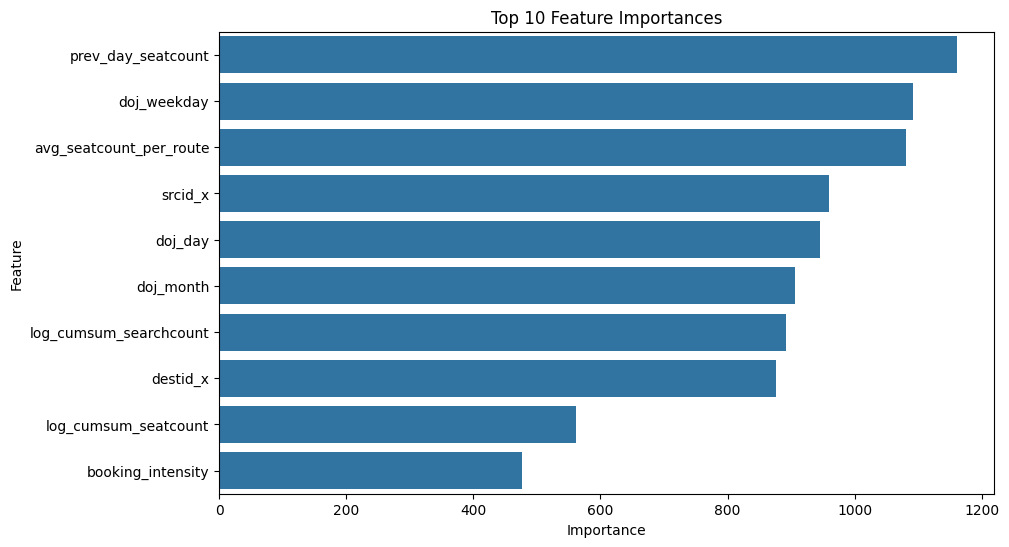

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ploting top 10 features
importances = model.feature_importances_
feature_names = X_train.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))
plt.title("Top 10 Feature Importances")
plt.show()

In [55]:
transactions['destid_region'].unique()

array(['Tamil Nadu', 'Karnataka', 'Andhra Pradesh', 'Maharashtra and Goa',
       'Delhi', 'Madhya Pradesh', 'Rest of North', 'East 1', 'Rajasthan',
       'Kerala'], dtype=object)

In [56]:
import holidays
from datetime import date

# Defining target years
years = [2022, 2023, 2024, 2025]


state_codes = {
    'Tamil Nadu': 'TN',
    'Karnataka': 'KA',
    'Andhra Pradesh': 'AP',
    'Maharashtra and Goa': ['MH', 'GA'],  
    'Delhi': 'DL',
    'Madhya Pradesh': 'MP',
    'Rajasthan': 'RJ',
    'Kerala': 'KL',
    'Rest of North': ['PB', 'HR', 'UK'], 
    'East 1': ['WB', 'OD']  
}


all_holidays = set()

# Looping through state codes and collecting holidays
for state, codes in state_codes.items():
    codes = codes if isinstance(codes, list) else [codes]
    for code in codes:
        try:
            h = holidays.India(years=years, prov=code)
            all_holidays.update(h.keys())
        except Exception as e:
            print(f"Skipped {code}: {e}")

# Converting to a set of date objects
holiday_dates = set(pd.to_datetime(list(all_holidays)).date)

In [57]:
for df in (train, test):
    df['doj_date'] = pd.to_datetime(df['doj_x'] if 'doj_x' in df else df['doj']).dt.date
    df['is_holidays'] = df['doj_date'].apply(lambda x: int(x in holiday_dates))

In [58]:
features.remove('is_holiday')
features.append('is_holidays')

In [59]:
X = train[features]
y = train['final_seatcount']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [60]:
model.fit(X_train[features], np.log1p(y_train))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1269
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 12
[LightGBM] [Info] Start training from score 7.434047


LGBMRegressor(colsample_bytree=0.8, max_depth=10, n_estimators=300,
              random_state=42, subsample=0.8)

In [61]:
val_preds = np.expm1(model.predict(X_val[features]))
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"\n Improved Validation RMSE: {rmse:.2f}")
print("New R²:", r2_score(y_val, val_preds))


 Improved Validation RMSE: 341.96
New R²: 0.9200786112303866


In [62]:
features

['srcid_x',
 'destid_x',
 'doj_day',
 'doj_weekday',
 'doj_month',
 'log_cumsum_seatcount',
 'log_cumsum_searchcount',
 'avg_seatcount_per_route',
 'booking_intensity',
 'doj_is_weekend',
 'prev_day_seatcount',
 'is_holidays']

In [63]:
for df in (train, test):
    if 'is_holiday' in df.columns:
        df.drop(columns=['is_holiday'], inplace=True)

## Outlier Detection & Removal

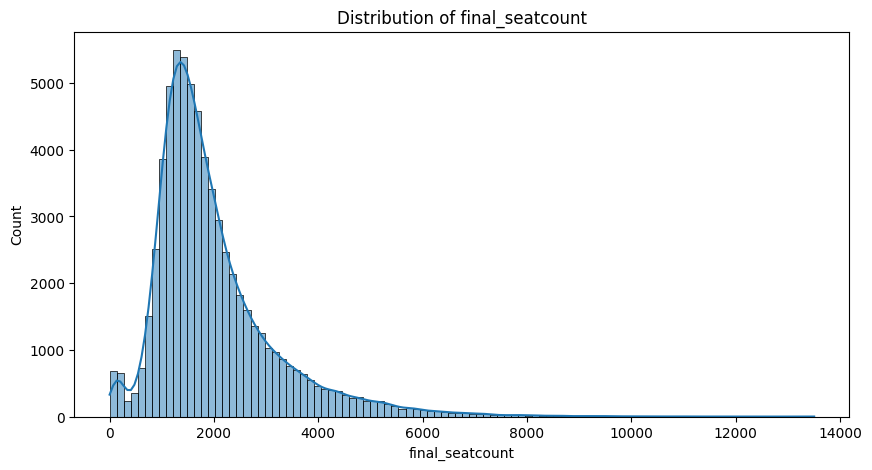

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(train['final_seatcount'], bins=100, kde=True)
plt.title("Distribution of final_seatcount")
plt.show()

In [65]:
Q1 = train['final_seatcount'].quantile(0.25)
Q3 = train['final_seatcount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Outliers below {lower_bound}, above {upper_bound}")

Outliers below -482.0, above 4142.0


In [66]:
train_clean = train[(train['final_seatcount'] >= lower_bound) & (train['final_seatcount'] <= upper_bound)]

In [67]:
# Shifting dbd to align previous day's seatcount
prev_day_map = transactions.copy()
prev_day_map['dbd'] = prev_day_map['dbd'] - 1
prev_day_map = prev_day_map[['doj', 'srcid', 'destid', 'dbd', 'cumsum_seatcount']]
prev_day_map.rename(columns={'cumsum_seatcount': 'prev_day_seatcount'}, inplace=True)


test['doj'] = pd.to_datetime(test['doj_x'])  

# Merging with test
test = test.merge(
    prev_day_map,
    left_on=['doj', 'srcid_x', 'destid_x'],
    right_on=['doj', 'srcid', 'destid'],
    how='left'
)



In [68]:
test.drop(columns=['srcid', 'destid'], inplace=True)

In [69]:
X = train_clean[features]
y = train_clean['final_seatcount']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, np.log1p(y_train))
val_preds = np.expm1(model.predict(X_val))

print("New RMSE:", np.sqrt(mean_squared_error(y_val, val_preds)))
print("New R²:", r2_score(y_val, val_preds))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1269
[LightGBM] [Info] Number of data points in the train set: 50447, number of used features: 12
[LightGBM] [Info] Start training from score 7.358748
New RMSE: 286.64428544963346
New R²: 0.8721134956123426


In [115]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, np.log1p(y_train))
xgb_preds = np.expm1(xgb.predict(X_val))

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, xgb_preds))
print("Final RMSE:", rmse)
print("Final R²:", r2_score(y_val, xgb_preds))

Final RMSE: 278.156631896349
Final R²: 0.879574910309061


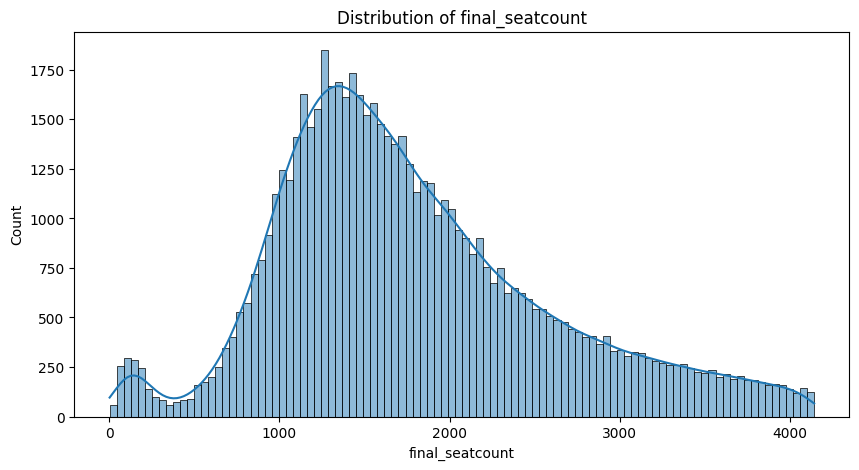

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(train_clean['final_seatcount'], bins=100, kde=True)
plt.title("Distribution of final_seatcount")
plt.show()

In [117]:
# Predict on test_clean and save
X_test = test[features]
xgb_test_preds = np.expm1(xgb.predict(X_test))
test['final_seatcount'] = xgb_test_preds

#  Final Submission

## The final submission is based on XGBoost predictions using all engineered features. We rounded and clipped the output to generate valid integer seat counts, ready for leaderboard evaluation.

In [ ]:
sample = pd.read_csv('sample_submission.csv') 
# Ensuring yur prediction DataFrame known as 'submission' and 'sample' has the same column names
submission = sample.copy()
submission = submission.merge(
    test[['route_key', 'final_seatcount']],
    on='route_key',
    how='left'
)


submission['final_seatcount'] = submission['final_seatcount_y'].round().astype(int)

submission['final_seatcount'] = submission['final_seatcount'].fillna(0)




In [119]:
submission.head()

,route_key,final_seatcount_x,final_seatcount_y,final_seatcount
0,2025-02-11_46_45,0,133.929031,134
1,2025-02-11_46_45,0,133.929031,134
2,2025-02-11_46_45,0,133.929031,134
3,2025-02-11_46_45,0,133.929031,134
4,2025-02-11_46_45,0,133.929031,134


In [120]:
# Dropping extra columns
submission = submission[['route_key', 'final_seatcount']]


In [121]:
submission.head()

,route_key,final_seatcount
0,2025-02-11_46_45,134
1,2025-02-11_46_45,134
2,2025-02-11_46_45,134
3,2025-02-11_46_45,134
4,2025-02-11_46_45,134


In [122]:
submission.shape

(182900, 2)

In [123]:
preds = test.groupby('route_key', as_index=False)['final_seatcount'].mean()

In [ ]:
# Merging cleanly into the sample
submission = sample.merge(preds, on='route_key', how='left')

In [125]:
submission.head()

,route_key,final_seatcount_x,final_seatcount_y
0,2025-02-11_46_45,0,133.929031
1,2025-01-20_17_23,0,118.719551
2,2025-01-08_02_14,0,131.251587
3,2025-01-08_08_47,0,99.292542
4,2025-01-08_09_46,0,126.004143


In [126]:
submission['final_seatcount'] = submission['final_seatcount_y'].round().astype(int)
submission['final_seatcount'] = submission['final_seatcount'].fillna(0)

# Dropping extra columns
submission = submission[['route_key', 'final_seatcount']]

submission.to_csv('submission_xgb_aligned.csv', index=False)

In [127]:
submission.head()

,route_key,final_seatcount
0,2025-02-11_46_45,134
1,2025-01-20_17_23,119
2,2025-01-08_02_14,131
3,2025-01-08_08_47,99
4,2025-01-08_09_46,126
